In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from keras.models import Model
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'Datasets//UCI HAR Dataset//')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'Datasets//UCI HAR Dataset//')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


In [2]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [3]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,6)]
    # loop over the six labels
    for i in range(6): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,5))
    
    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        # apply  PyWavelets continuous wavelet transfromation function
        coeffs, freqs = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
        # create scalogram
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt

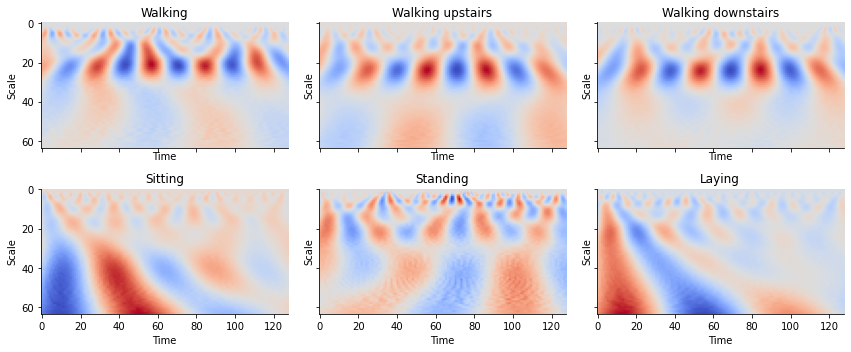

In [4]:
# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(trainy)
LABEL_NAMES = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]
#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet

plot_cwt_coeffs_per_label(trainX, train_labels_indicies, LABEL_NAMES, signal, sample, scales, wavelet)


In [5]:
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64

trainX_cwt = create_cwt_images(trainX, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {trainX_cwt.shape}")
testX_cwt = create_cwt_images(testX, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {testX_cwt.shape}")

0
1000
2000
3000
4000
5000
6000
7000
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (7352, 64, 64, 9)
0
1000
2000
shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (2947, 64, 64, 9)
